# Inside the Harry Potter Universe

In [1]:
from __future__ import absolute_import, division, print_function

import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Prepare Corpus

In [6]:
book_filenames = sorted(glob.glob("data/HP/*"))

In [7]:
print("Found books:")
book_filenames

Found books:


['data/HP/1',
 'data/HP/2',
 'data/HP/3',
 'data/HP/4',
 'data/HP/5',
 'data/HP/6',
 'data/HP/7']

### Combine all the books to form single string

In [8]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/HP/1'...
Corpus is now 439741 characters long

Reading 'data/HP/2'...
Corpus is now 931872 characters long

Reading 'data/HP/3'...
Corpus is now 1543477 characters long

Reading 'data/HP/4'...
Corpus is now 2659164 characters long

Reading 'data/HP/5'...
Corpus is now 4140935 characters long

Reading 'data/HP/6'...
Corpus is now 5126541 characters long

Reading 'data/HP/7'...
Corpus is now 6259097 characters long



#### Split the corpus into sentences

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [11]:
# convert into a list of words
# remove unnnecessary, split into words, no hyphens
# list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [12]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [13]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The Dursleys had a small son called Dudley and in their
opinion there was no finer boy anywhere.
[u'The', u'Dursleys', u'had', u'a', u'small', u'son', u'called', u'Dudley', u'and', u'in', u'their', u'opinion', u'there', u'was', u'no', u'finer', u'boy', u'anywhere']


In [55]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop_removed_sentences = []
for sentence in sentences:
    stop_removed_sentences.append(list(set(sentence) - stop))
    
print(len(stop_removed_sentences))

sentences = stop_removed_sentences

85794


In [14]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,121,147 tokens


## Training the Word2Vec Model

In [3]:
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

seed = 1

In [15]:
hp2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [16]:
hp2vec.build_vocab(sentences)

In [17]:
print("Word2Vec vocabulary length:", len(hp2vec.vocab))

Word2Vec vocabulary length: 13190


#### Begin training the model

In [18]:
hp2vec.train(sentences)

4245425

#### Save the trained model

In [17]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [19]:
hp2vec.save(os.path.join("trained", "hp2vec.w2v"))

#### Reload the trained model in case necessary

In [102]:
hp2vec = w2v.Word2Vec.load(os.path.join("trained", "hp2vec.w2v"))

## T-SNE Plots

### Compress the vectors in 2D space and visualise the plot to get a better idea of word correlations

In [19]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [20]:
all_word_vectors_matrix = hp2vec.syn0

#### Train a T-SNE model

In [21]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [22]:
# Plot the data
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[hp2vec.vocab[word].index])
            for word in hp2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [23]:
points.head(10)

,word,x,y
0,raining,5.459159,-4.844335
1,both,-2.725495,1.978752
2,yellow,-0.254700,-6.475333
3,four,4.627518,2.880761
4,rocketing,4.633547,-2.826837
5,woods,6.219671,-3.785739
6,spiders,3.643498,-6.419507
7,hanging,1.127626,-5.688153
8,conjuring,4.930159,-2.027467
9,Until,-3.646941,-2.110819


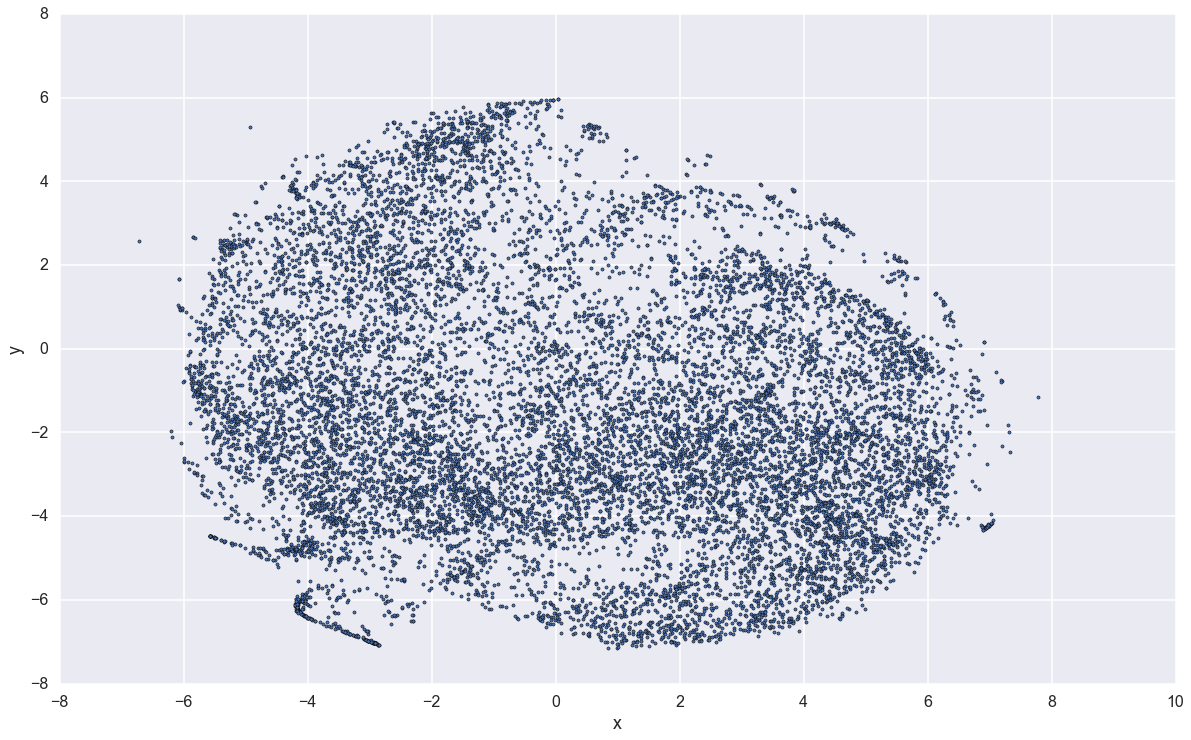

In [24]:
sns.set_context("poster")

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [25]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 12))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

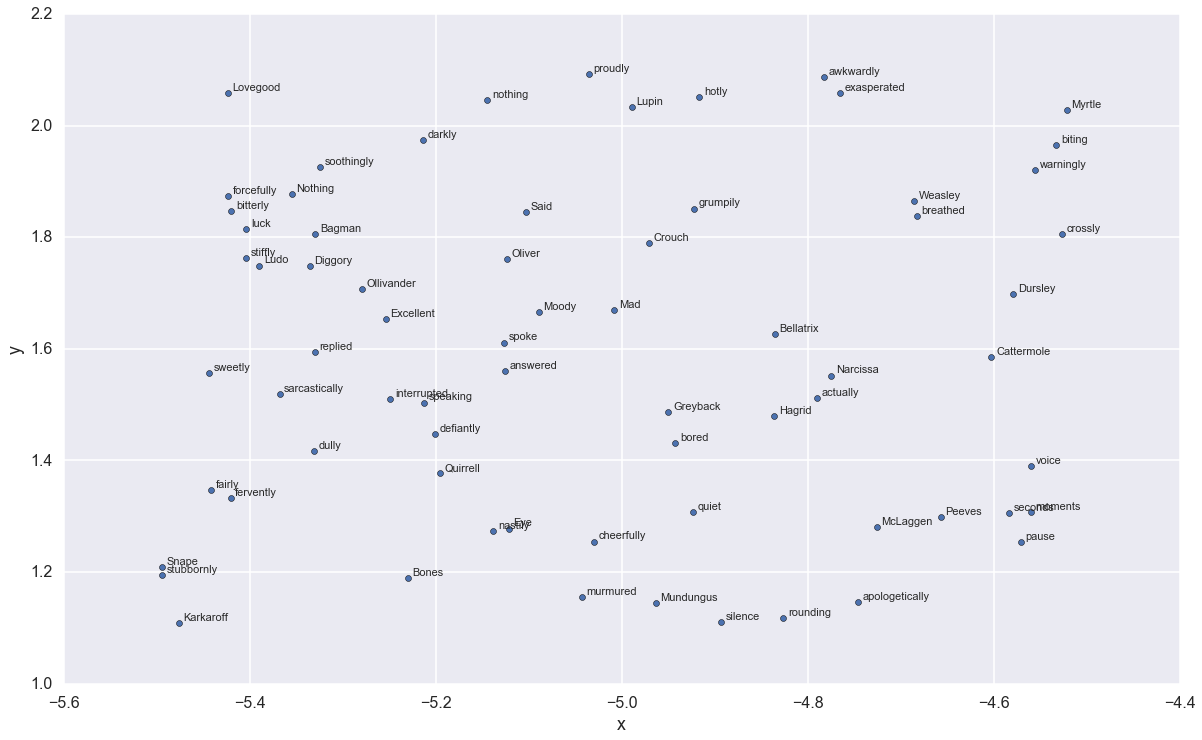

In [138]:
plot_region(x_bounds=(-5.5,-4.5), y_bounds=(1.1, 2.1))

In [143]:
hp2vec.most_similar('Dobby')

[(u'Kreacher', 0.7488130331039429),
 (u'Master', 0.7420558929443359),
 (u'elf', 0.741797924041748),
 (u'sir', 0.738074541091919),
 (u'Winky', 0.7340859174728394),
 (u'Wormtail', 0.6496269702911377),
 (u'Firenze', 0.6393516659736633),
 (u'Ollivander', 0.6310637593269348),
 (u'Griphook', 0.6310436725616455),
 (u'Parseltongue', 0.6239023804664612)]

In [109]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = hp2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [134]:
nearest_similarity_cosmul("Slytherin", "Malfoy", "Harry")
nearest_similarity_cosmul("Vernon", "Petunia", "Lily")
nearest_similarity_cosmul("Sirius", "Regulus", "Fred")
nearest_similarity_cosmul("Dobby", "Malfoy", "Black")

Slytherin is related to Malfoy, as Gryffindor is related to Harry
Vernon is related to Petunia, as James is related to Lily
Sirius is related to Regulus, as George is related to Fred
Dobby is related to Malfoy, as Kreacher is related to Black


u'Kreacher'